In [5]:
import control as ctrl
import matplotlib.pyplot as plt
import numpy as np

In [1]:
def derivs_tclab(t, x, u, params):
    "Las ecuaciones de las derivadads en las ecuaciones de estados"
    Q1 = u[0]
    Q2 = u[1]
    Ta=params.get('Ta', 19)
    P1max=params.get('P1max', 100)
    P2max=params.get('P2max', 200)
    H1 = x[0]
    H2 = x[1]
    T1 = x[2]
    T2 = x[3]
    DeltaTaH1 = Ta - H1
    DeltaTaH2 = Ta - H2
    DeltaT12 = H1 - H2
    dH1 = P1max * Q1 / 5720 + DeltaTaH1 / 20 - DeltaT12 / 100
    dH2 = P2max * Q2 / 5720 + DeltaTaH2 / 20 + DeltaT12 / 100
    dT1 =(H1 - T1)/140
    dT2 = (H2 - T2)/140
    return [dH1, dH2, dT1, dT2]


def output_tclab(t, x, u, params):
    "Las ecuaciones de las salidas en las ecuaciones de estados"
    return [x[2], x[3]]

Se define el sistema no lineal usando las ecuaciones anteriores

In [3]:
sys=ctrl.NonlinearIOSystem(derivs_fun, output_fun, inputs=('Q1', 'Q2'), outputs=('T1', 'T2'))

Vemos como evoluciona desde condiciones iniciales de 30 grados, con la temperatura ambiente seteada en el modelo en 19 grados, con entradas en 0.

In [4]:
X0 = [30,30, 30, 30]
T=np.linspace(0,2000, 2000)

t,y = ctrl.input_output_response(sys, T, 0, X0)

Ahora grafico la evolución

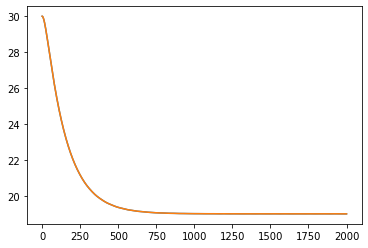

In [5]:
plt.plot(t,y[0,:])
plt.plot(t,y[1,:])

Defino ahora otra señal de entrada: Q1 = 50 entre t 400 y 1600 y para Q2= 50  entre t > 1200

In [6]:
def Usignal(T):
    U = np.zeros((2, len(T)))
    for i, t in enumerate(T):
        U[0,i] = 50 if t > 400 and t < 1600 else  0
        U[1,i] = 50 if t > 1200 else  0
        
    return U

U=Usignal(T)



Veamos como son las señales de entrada 

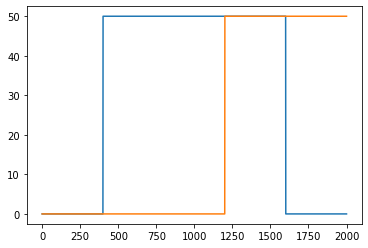

In [7]:
plt.plot(T,U[0,:])
plt.plot(T,U[1,:])

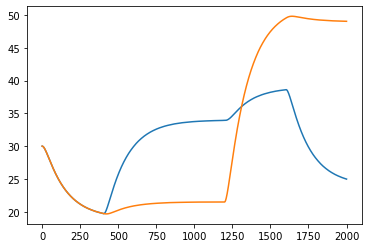

In [8]:
t,y = ctrl.input_output_response(sys, T, U, X0)
plt.plot(t,y[0,:])
plt.plot(t,y[1,:])

In [9]:
PI = 0.04*ctrl.tf([1/2400,1],[1,0])
PIio=ctrl.LinearIOSystem(PI, inputs=('e'), outputs=('Q1'))

In [10]:
sum1 = ctrl.summing_junction(inputs=['r', '-T1'], output='e')

In [11]:
sys=ctrl.NonlinearIOSystem(derivs_fun, output_fun, inputs=['Q1', 'Q2'], outputs=['T1', 'T2'], states=['H1', 'H2', 'T1', 'T2'])
sys_controlado = ctrl.interconnect([sum1, sys, PIio], inplist=['r', 'Q2'], outlist=['T1','T2'])

In [12]:
def Usignal(T):
    U = np.zeros((2, len(T)))
    for i, t in enumerate(T):
        U[0,i] = 35
        U[1,i] = 20 if t > 1200 else  0
        
    return U

U=Usignal(T)


In [13]:
X0=[19,19,19,19,0]
t,y = ctrl.input_output_response(sys_controlado, T, U, X0)

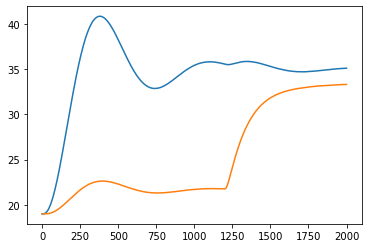

In [14]:
plt.plot(T,y[0,:])
plt.plot(T,y[1,:])

### Problema CSTR:

In [6]:
cA0 = 0.5  # mol/L
T0 = 350  # K 



In [7]:
def derivs_CSTR(t, x, u, params):
    
    q = params.get('q', 100)   # L/min 
    # cA_i = params.get('cAi', 1)  # mol/L
    T_i = params.get('T_i', 350)  # K 
    V = params.get('V', 100)  # L
    rho = params.get('rho', 1000) # g/L
    C = params.get('C', 0.239) # J/(g K)
    Hr = params.get('Hr', -5e4)  # J/(g K)
    E_over_R = params.get('E_over_R', 8750)  # K
    k0 = params.get('ko', 7.2e10)   # 1/min
    UA = params.get('UA', 5e2)  # J/(L K)
    Tc = params.get('Tc', 300)  # K
    
    qc, cA_i= u 
    cA, T = x
    
    k = k0*np.exp(-E_over_R/T)
    w = q*rho
    dcAdt = q*(cA_i - cA)/V - k*cA
    dTdt = 1/(V*rho*C)*(w*C*(T_i - T) - Hr*V*k*cA + UA*(Tc - T)*qc)
    return dcAdt, dTdt

def outputs_CSTR(t, x, u, params):
    return x[0], x[1]
    


In [8]:
CSTR_sys=ctrl.NonlinearIOSystem(derivs_CSTR, 
                                outputs_CSTR, 
                                inputs=('Tc', 'CA_i'), 
                                outputs=('cA', 'T'), 
                                states=('dcA', 'dT'))

In [9]:
T = np.linspace(0, 10, 1000)
x0 = [cA0, T0]

def Usignal(T):
    U = np.zeros((2, len(T)))
    for i, t in enumerate(T):
        U[0,i] = 100
        U[1,i] = 1
        
    return U

U=Usignal(T)

In [10]:
t,y = ctrl.input_output_response(CSTR_sys, T, U, x0)

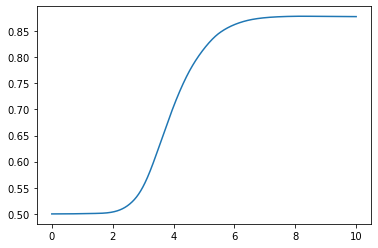

In [11]:
plt.plot(t,y[0,:])


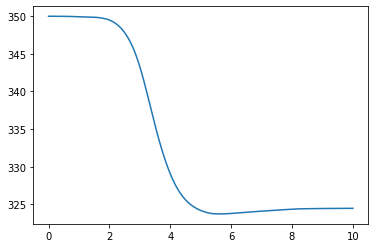

In [12]:
plt.plot(t,y[1,:])

In [43]:
x0, U0 = ctrl.find_eqpt(CSTR_sys, x0, [300,1])
x0

array([  0.49991829, 350.00552869])

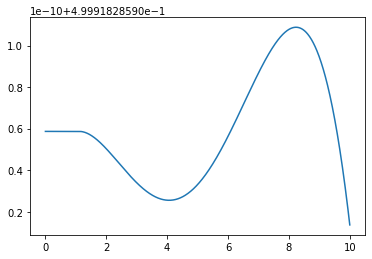

In [44]:
t,y = ctrl.input_output_response(CSTR_sys, T, U, x0)
plt.plot(t,y[0,:])


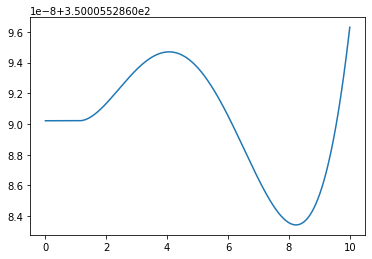

In [45]:
plt.plot(t,y[1,:])